# Analyzing Play Time Contribution by Different Player Types

## Introduction

PLAI, an AI research group within the Faculty of Computer Science at UBC, has set up a Minecraft server to develop an AI that surpasses current technological constraints. Through this server, the researchers have gathered data on participants' in-game actions and communication, with the goal of collecting over 10,000 hours of data to create a complex AI that replicates player-like behaviour within the virtual world, or similarly, an AGI (Artificial General Intelligence)-like agent. However, to gather more significant data, PLAI researchers aim to identify which players, or player types, contribute the most hours of gameplay. Therefore, this analysis will address the following question: Can we determine which players are most likely to contribute the most hours of gameplay based on their age and experience with the game?

To answer the question, this project uses two datasets containing player information and session details: ```players.csv``` and ```sessions.csv```.

*[ ] indicates variable data type

---

```players.csv```: A dataset containing identifying information provided during recruitment for all participants, including their total playtime. It contains 196 **observations** and 9 **variables**.

- ```experience```: Participant's self-reported Minecraft experience level [Character/Categorical] - (Amateur, Beginner, Regular, Pro, Veteran).
- ```subscribe```: Whether the participant is subscribed to PLAI emails [Character].
- ```hashedEmail```: The participant's provided email address, encrypted for privacy [Character]. 
- ```played_hours```: Total number of hours the participant has played on the server [Double].
- ```name```: The participant's provided name [Character].
- ```gender```: The participant's identified gender [Character].
- ```age```: The participant's age [Double].
- ```IndividualID```: The participant's ID; another means of identification [Logical].*
- ```organizationName```: The participant's affiliated organization [Logical].*

*Note: **IndividualID** and **organizationName** are labelled as NA and are not provided in the dataset.

---


```sessions.csv```: A dataset containing each play session per individual, including their start and end times. It contains 1535 **observations** and 5 **variables**. 

- ```hashedEmail```: The participant's provided email address, encrypted for privacy [Character].
- ```start_time```: Session start date (dd/mm/yyyy) and time (24hr) [Character].
- ```end_time```: Session end date (dd/mm/yyyy) and time (24hr) [Character].
- ```original_start_time```: Session start time in UNIX timestamp - seconds since Jan 1st, 1970 (UTC) [Double].
- ```original_end_time```: Session end time in UNIX timestamp - seconds since Jan 1st, 1970 (UTC) [Double].

---

## Methods & Results

We will use **KNN-Classification** with `age` and `played_hours` as predictor variables, identifying the types of players that have the highest playtime. To address the question, we will use the categorical variable, `experience`, to classify players as **Amateurs**, **Beginners**, **Regulars**, **Pros**, or **Veterans**.

---
### Loading the packages into R

To begin the analysis, we loaded the following **packages**:
1. ```tidyverse``` - Contains most of the basic functions needed for analysis (ex. data wrangling)

2. ```RColorBrewer``` - Introduces additional color palettes for visualization, which is important for addressing colorblindness. 

3. ```tidymodels``` - Provides functions necessary to train and create the KNN-classification model. 

4. ```repr``` - Contains functions to control how R objects are displayed (ex. Reformatting visualizations)

5. ```themis``` - Includes the ```step_upsample``` function needed for balancing the ```experience``` class. 

The ```options``` function, used with the ```matrix``` argument, controls the number of rows displayed per data frame. We specify that 5 rows should be displayed. 


In [2]:
#Contains most functions needed for analysis
library(tidyverse) 

#To obtain colors for visualization: Colorblind-friendly Palettes
library(RColorBrewer) 


#Contains the functions to create a model
library(tidymodels)

#Controls how R objects are displayed. Enhances the details of outputs by indirectly formatting how they appear (ex. options). 
library(repr)

#To balance the experience classes
library(themis)

#To obtain a maximum of 5 rows per data frame
options(repr.matrix.max.rows = 5) 

### Reading the datasets into R

Next, we loaded both ```players.csv``` and ```sessions.csv``` into the analysis using the ```read_csv``` function and their respective URLs. 

The data frames were assigned to their respective names: ***players*** and ***sessions***.

In [3]:
#Loading both datasets (players and session data) into the datafile. 
players <- read_csv ("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

sessions <- read_csv ("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling
In this section, we wrangled the data into a usable, tidy format. From this, we created a data frame containing only the variables of interest: ```experience```, ```played_hours```, and ```age```.

1. First, we use the ```set.seed``` function to set a **seed** with a value of **100**. This ensures that functions requiring randomness will produce the same results when the same code is run in other instances.

2. Using the ```merge``` function, both **players** and **sessions** were combined based on matching ```hashedEmail``` variable values. Separate instances (ex. different ```start_time``` and ```end_time``` values were treated as separate observations.

3. The merged dataset was further refined using the ```select``` function to create a data frame containing only the variables of interest.

4. Finally, values equal to 0 were removed from the ```played_hours``` variable using the ```filter``` function, as they are not meaningful to the analysis. Moreover, to create a visualization, we would need to scale the y-axis to spread the points out, preventing increased overplotting. This would result in values of 0 becoming infinity, which is problematic considering we are using KNN-classification (ex. KNN-classification could consider these values as hours > 0, when in reality, they are 0).

5. The ```head``` and ```tail```functions were used to display the first and last 6 rows of the wrangled dataset.

In [13]:
#Setting the seed. (1)
set.seed (100)

#Wrangling the data - Begin by merging sessions.csv and players.csv together based on matching values of the hashedEmail variable. (2)
playdate <- merge (x = players, y = sessions, by = "hashedEmail", all = TRUE)

#Selecting the columns of interest (experience, played_hours, age). (3)
playdate_select <- playdate |>
select (experience, played_hours, age)

#Remove all values of "played_hours" that equal to 0. (4)
playdate_final <- playdate_select |>
filter (played_hours > 0)

#Printing out the first and last 6 rows to see what we are working with. (5)
head(playdate_final, 6)
tail (playdate_final, 6)

,experience,played_hours,age
,<chr>,<dbl>,<dbl>
1,Regular,1.5,20
2,Regular,1.5,20
3,Pro,0.4,21
⋮,⋮,⋮,⋮
5,Regular,5.6,17
6,Regular,5.6,17


,experience,played_hours,age
,<chr>,<dbl>,<dbl>
1516,Amateur,56.1,23
1517,Amateur,56.1,23
1518,Amateur,56.1,23
⋮,⋮,⋮,⋮
1520,Amateur,0.1,17
1521,Beginner,1.1,20


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


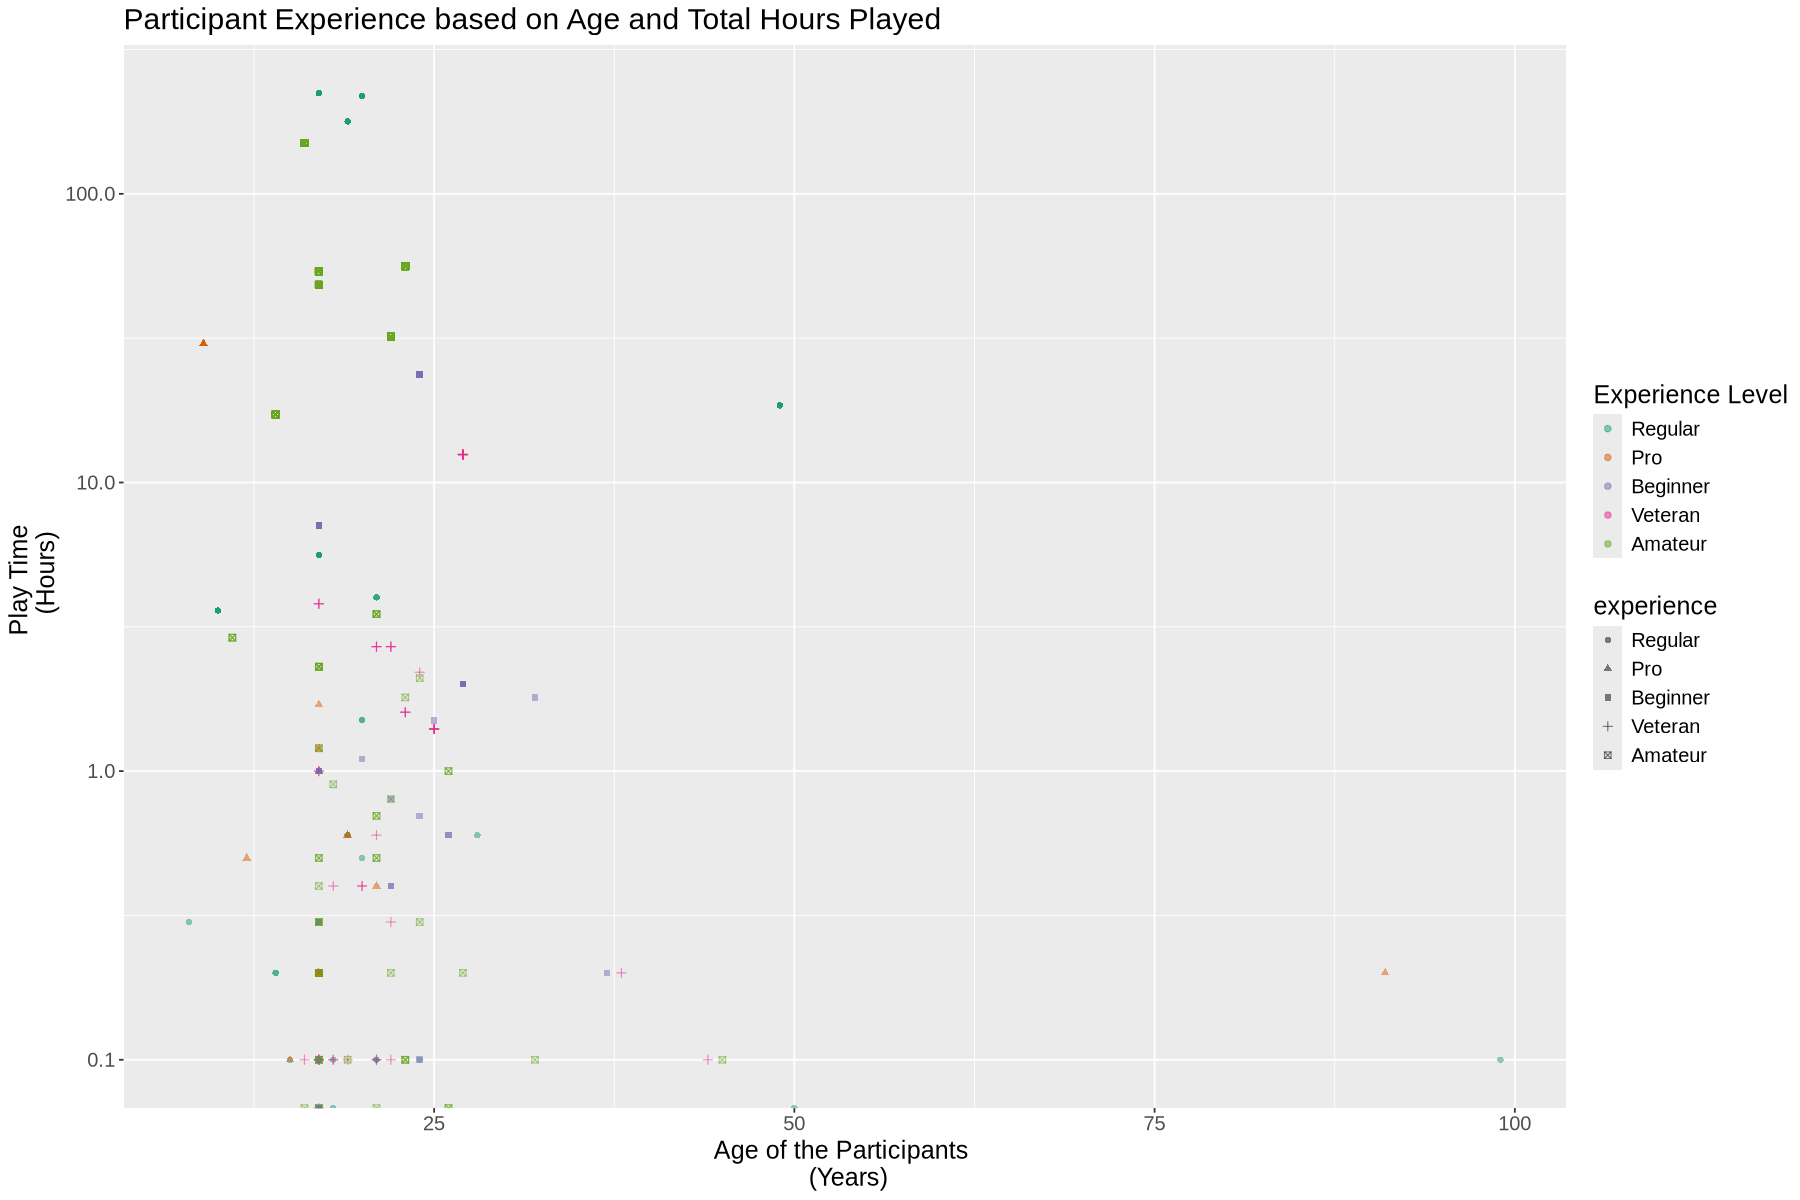

In [79]:
#Copy and reword this code if we don't need start_time, end_time, and difference:
options (repr.plot.width = 15, repr.plot.height = 10)


#Final Cleaning of the data and turning the experience variable to a categorical variable
playdate_final <- playdate_diff |>
select (experience:age) |>
mutate (experience = as_factor(experience))

#Creating a visualization to see what we're working with; x = age as it is independent, y = played_hours as it might change based on age
playdate_vision <- playdate_final |>
ggplot (aes(x = age, y = played_hours, color = experience, shape = experience)) +
geom_point(alpha = 0.5) +
scale_color_brewer (palette = "Dark2") +
labs (x = "Age of the Participants \n (Years)", y = "Play Time \n (Hours)", title = "Participant Experience based on Age and Total Hours Played"
      , color = "Experience Level") +
theme (text = element_text (size = 15)) +
scale_y_log10 ()

playdate_vision

In [101]:
#Creating the model 

#Split the data into a training and testing set
playdate_split <- playdate_final |>
initial_split (prop = 0.75, strata = experience)

#Obtain the training and testing sets 
playdate_training <- training (playdate_split)
playdate_testing <- testing (playdate_split)

#Creating the recipe
playdate_recipe <- recipe (experience ~., data = playdate_training) |>
                        step_scale (all_predictors()) |>
                        step_center (all_predictors()) |>
                        step_upsample (experience, over_ratio = 1, skip = TRUE)

#Creating the tuning model 
playdate_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
                    set_engine ("kknn") |>
                    set_mode ("classification")


#Creating the validation data set 
playdate_vfold <- vfold_cv (playdate_training, v = 5, strata = experience)


#Creating the tibble function for the K values
k_vals <- tibble (neighbors = seq (from = 1, to = 100, by = 1))

#Creating the workflow
knn_tune_results <- workflow () |>
add_model (playdate_tune) |>
add_recipe (playdate_recipe) |>
tune_grid (resamples = playdate_vfold, grid = k_vals) |>
collect_metrics ()

#Filter the metrics just for accuracy
knn_tune_accuracy <- knn_tune_results |>
filter (.metric == "accuracy") |>
arrange (desc(mean)) 

knn_tune_accuracy




neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9338708,5,0.008497891,Preprocessor1_Model001
2,accuracy,multiclass,0.9338708,5,0.008497891,Preprocessor1_Model002
5,accuracy,multiclass,0.9243168,5,0.006445244,Preprocessor1_Model005
⋮,⋮,⋮,⋮,⋮,⋮,⋮
89,accuracy,multiclass,0.8190301,5,0.02023939,Preprocessor1_Model089
90,accuracy,multiclass,0.8190301,5,0.02023939,Preprocessor1_Model090


## Discussion

Further research could be done on how to identify or classify a player as one of the five types. For example, what makes a specific player a pro level? An amateur level?

## References

For the merge function: https://stackoverflow.com/questions/1299871/how-to-join-merge-data-frames-inner-outer-left-right

For POSIXct: https://stackoverflow.com/questions/43460329/converting-datetime-from-character-to-posixct-object

For difftime() function: https://www.statology.org/r-difftime-function/#:~:text=You%20can%20use%20the%20difftime,dates%20or%20datetimes%20in%20R.&text=where%3A,%E2%80%9D%2C%20and%20%E2%80%9Cweeks%E2%80%9D)